### **1. Import the Required Libraries**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm
import urllib
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import os
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.metrics import cohen_kappa_score
import matplotlib.cm as cm
from sklearn.metrics import matthews_corrcoef
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Read Data**

In [3]:
image_path="/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"

In [4]:
train_image_path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
valid_image_path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

test_image_path="./kaggle/input/new-plant-diseases-dataset/test/test/"

# **Data Analysis**

**class name**

In [12]:
IMG_WIDTH = 100
IMG_HEIGHT = 100
batch_size=32

# **Train_data,Valid_data and Test_data Generator**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_image_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 70295 images belonging to 38 classes.


In [14]:
testdata_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data_generator=testdata_generator.flow_from_directory(valid_image_path,batch_size=batch_size,class_mode="categorical",
                                                           target_size=(IMG_WIDTH,IMG_HEIGHT),color_mode="rgb",shuffle=False )

Found 17572 images belonging to 38 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(valid_image_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=batch_size,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 17572 images belonging to 38 classes.


In [16]:
train_number=train_generator.samples
valid_number=validation_generator.samples

### **Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **Create a CNN Model**

In [17]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=38, activation='sigmoid')
    ])

    return model

In [18]:
cnn_model = create_model()

In [19]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 128)       9728      
                                                                 
 activation (Activation)     (None, 96, 96, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 48, 48, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

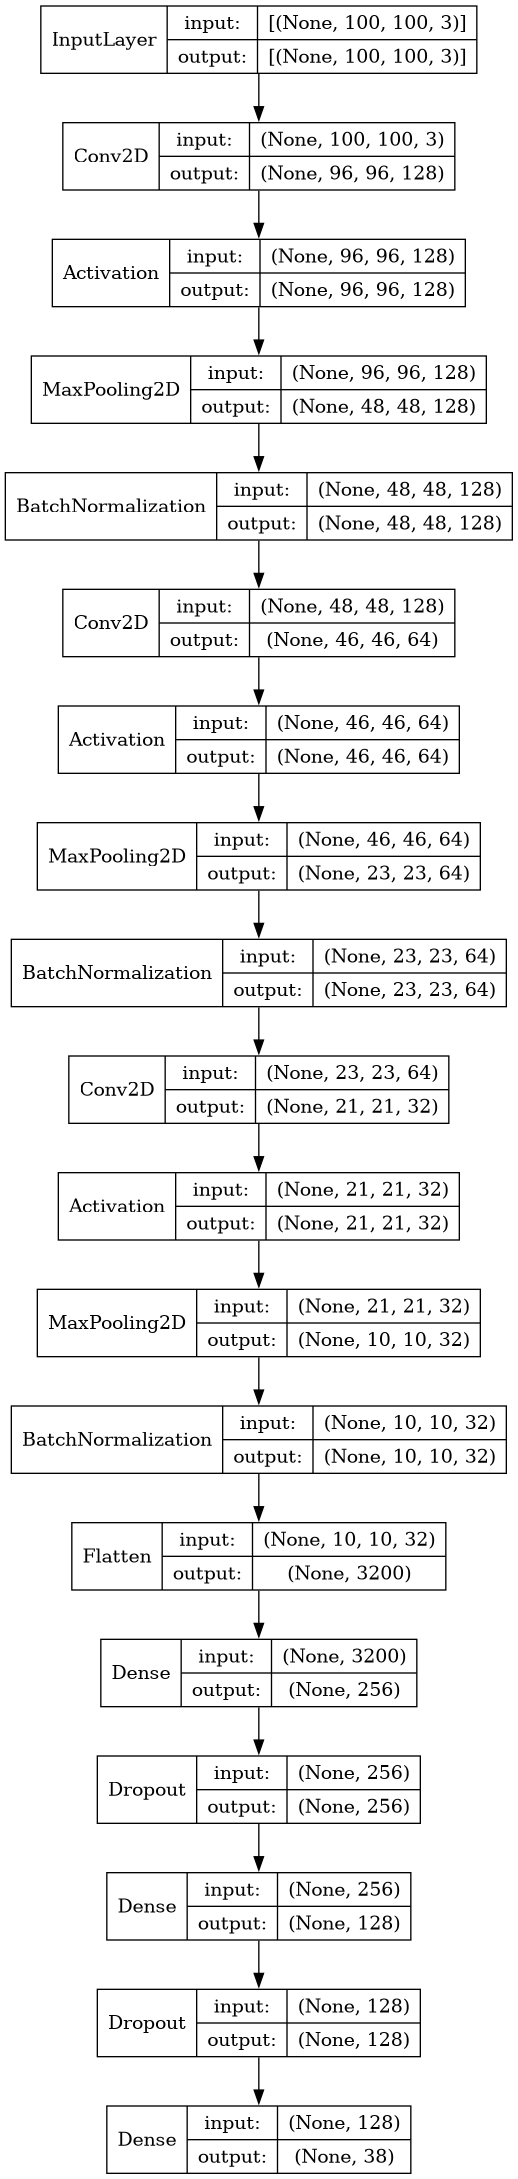

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(cnn_model, expand_nested=True, show_shapes=True, show_layer_names=False)

#### **Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **Defining the Optimizer**

In [22]:
optimizer = Adam(learning_rate=0.0001)

#### **Compile the Model**

In [23]:
cnn_model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'],loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

#### **Training the Model**

In [24]:
history = cnn_model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=train_number // batch_size,
                        epochs=50, 
                        validation_steps=valid_number // batch_size,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
2196/2196 - 310s - loss: 3.0481 - accuracy: 0.2009 - val_loss: 1.9674 - val_accuracy: 0.4587 - lr: 1.0000e-04 - 310s/epoch - 141ms/step
Epoch 2/50
2196/2196 - 294s - loss: 2.1961 - accuracy: 0.3840 - val_loss: 2.3190 - val_accuracy: 0.4074 - lr: 1.0000e-04 - 294s/epoch - 134ms/step
Epoch 3/50
2196/2196 - 320s - loss: 1.7778 - accuracy: 0.4901 - val_loss: 2.2427 - val_accuracy: 0.4588 - lr: 1.0000e-04 - 320s/epoch - 146ms/step
Epoch 4/50
2196/2196 - 315s - loss: 1.4860 - accuracy: 0.5702 - val_loss: 0.9886 - val_accuracy: 0.7058 - lr: 1.0000e-04 - 315s/epoch - 143ms/step
Epoch 5/50
2196/2196 - 292s - loss: 1.2890 - accuracy: 0.6236 - val_loss: 1.6532 - val_accuracy: 0.5923 - lr: 1.0000e-04 - 292s/epoch - 133ms/step
Epoch 6/50
2196/2196 - 292s - loss: 1.1282 - accuracy: 0.6690 - val_loss: 0.7431 - val_accuracy: 0.7560 - lr: 1.0000e-04 - 292s/epoch - 133ms/step
Epoch 7/50
2196/2196 - 290s - loss: 1.0104 - accuracy: 0.7034 - val_loss: 2.1606 - val_accuracy: 0.5604 - lr: 1.0000e-

### **Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [26]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

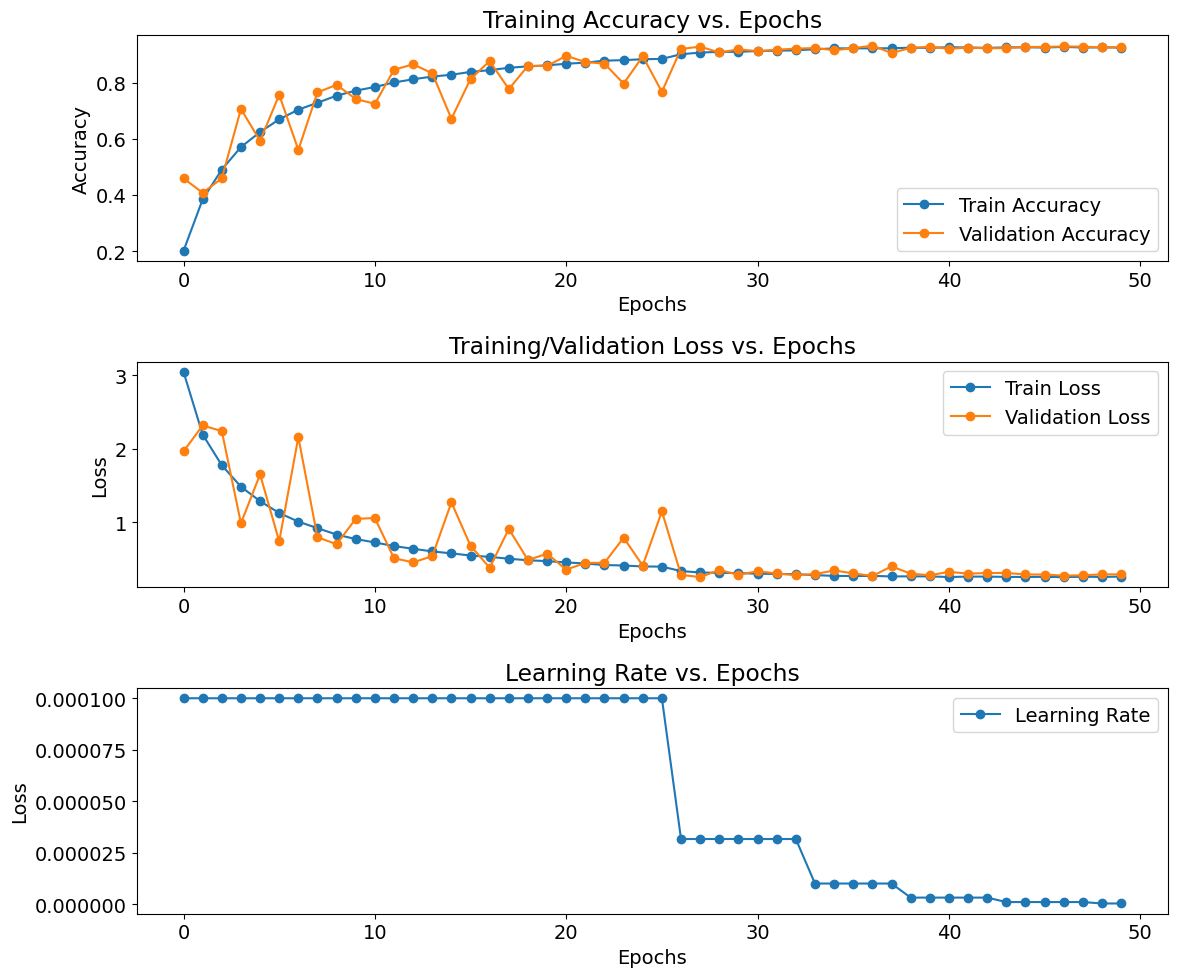

In [27]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

# **Save Model**

In [75]:
cnn_model.save("model.h5")
from tensorflow.keras.models import load_model

cnn_model = load_model("/kaggle/working/model.h5")

### **Model Prediction on the Test Dataset**

In [38]:
predictions = cnn_model.predict(test_data_generator)

550/550 [==============================] - 25s 46ms/step


In [40]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Apple___Apple_scab
1 : Apple___Black_rot
2 : Apple___Cedar_apple_rust
3 : Apple___healthy
4 : Blueberry___healthy
5 : Cherry_(including_sour)___Powdery_mildew
6 : Cherry_(including_sour)___healthy
7 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
8 : Corn_(maize)___Common_rust_
9 : Corn_(maize)___Northern_Leaf_Blight
10 : Corn_(maize)___healthy
11 : Grape___Black_rot
12 : Grape___Esca_(Black_Measles)
13 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14 : Grape___healthy
15 : Orange___Haunglongbing_(Citrus_greening)
16 : Peach___Bacterial_spot
17 : Peach___healthy
18 : Pepper,_bell___Bacterial_spot
19 : Pepper,_bell___healthy
20 : Potato___Early_blight
21 : Potato___Late_blight
22 : Potato___healthy
23 : Raspberry___healthy
24 : Soybean___healthy
25 : Squash___Powdery_mildew
26 : Strawberry___Leaf_scorch
27 : Strawberry___healthy
28 : Tomato___Bacterial_spot
29 : Tomato___Early_blight
30 : Tomato___Late_b

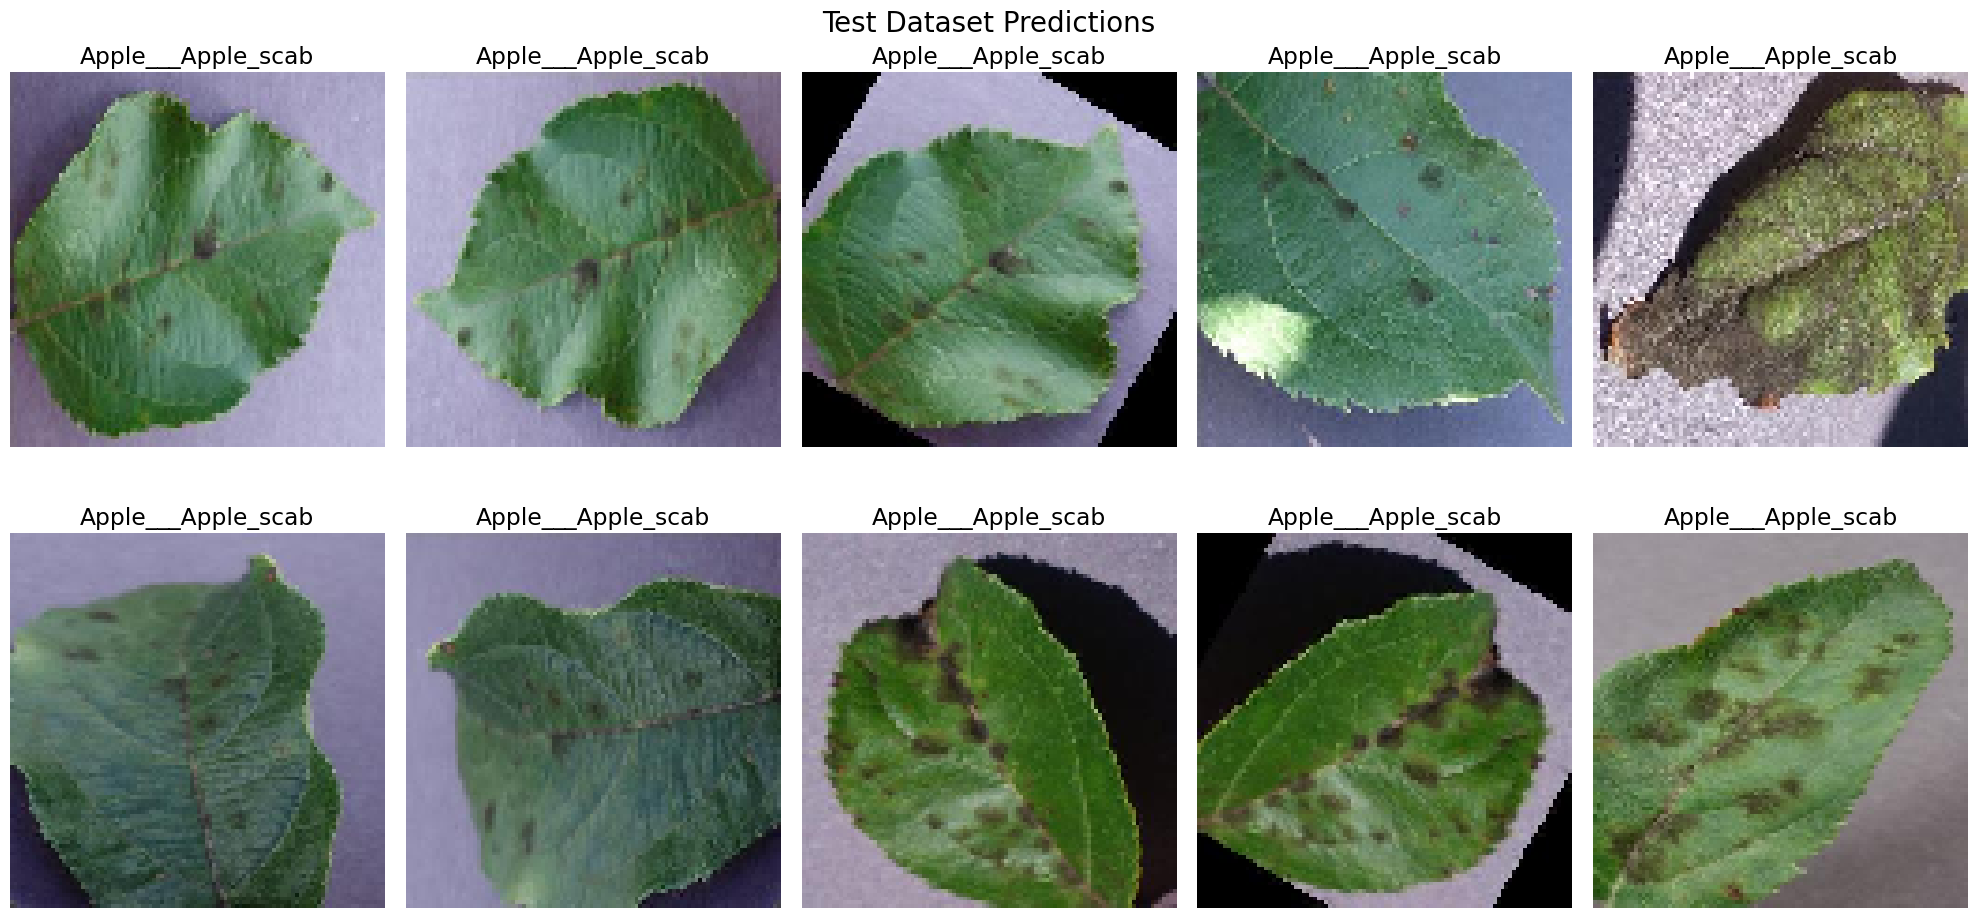

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_data_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [52]:
test_loss, test_accuracy = cnn_model.evaluate(test_data_generator, batch_size=batch_size)

550/550 [==============================] - 26s 47ms/step - loss: 0.2932 - accuracy: 0.9251


In [53]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.29315638542175293
Test Accuracy: 0.9251081347465515


In [55]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_data_generator.classes

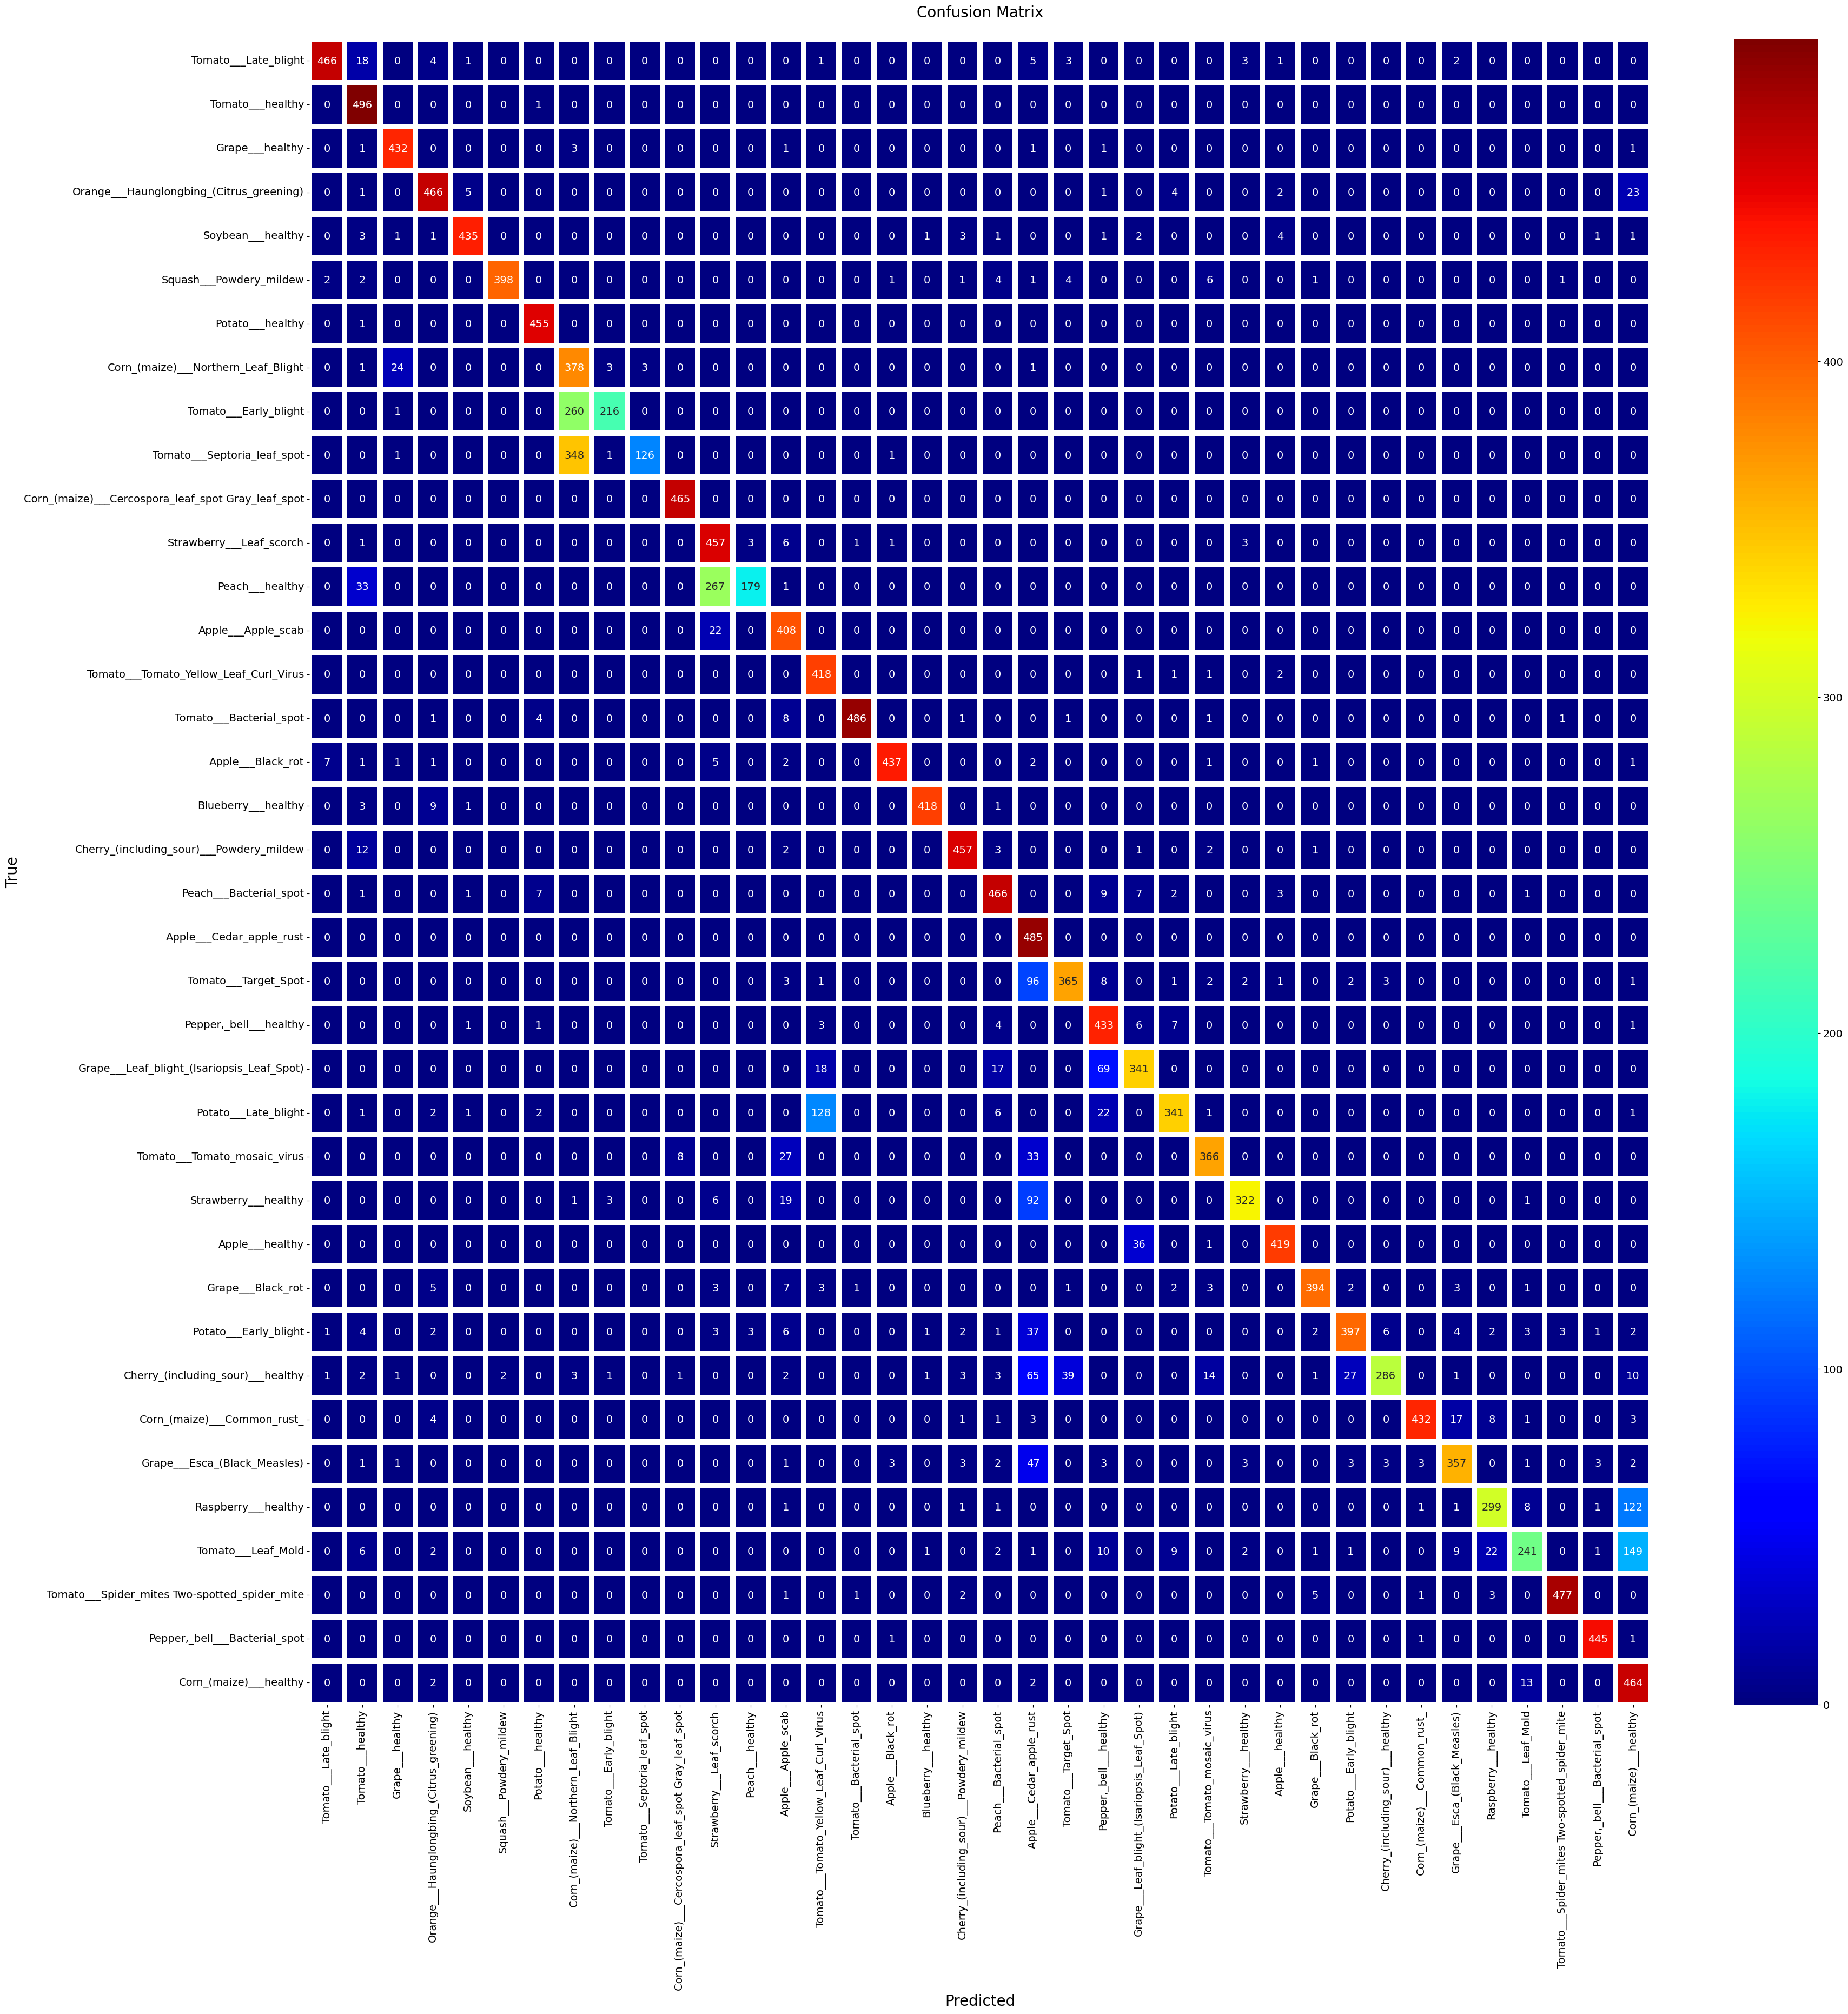

In [57]:
plt.figure(figsize=(40,40))
confusion = confusion_matrix(true_data, final_predict)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=class_names,
            yticklabels=class_names,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()

In [58]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.92      0.95       504
                                 Apple___Black_rot       0.84      1.00      0.91       497
                          Apple___Cedar_apple_rust       0.94      0.98      0.96       440
                                   Apple___healthy       0.93      0.93      0.93       502
                               Blueberry___healthy       0.98      0.96      0.97       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.95      0.97       421
                 Cherry_(including_sour)___healthy       0.97      1.00      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.38      0.92      0.54       410
                       Corn_(maize)___Common_rust_       0.96      0.45      0.62       477
               Corn_(maize)___Northern_Leaf_Blight       0.98      0.26      0.